In [1]:
import math
import json
#import cv
import gc
import numpy as np
import numpy.ma as ma

import keras
from keras import backend as K
from keras.utils import np_utils
from keras.engine import Layer

from keras.layers import Input, Dense, Convolution3D, MaxPooling3D, Reshape, Flatten, BatchNormalization, Lambda, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model, Sequential, model_from_json
from keras.utils import multi_gpu_model
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from keras.models import load_model


In [2]:
#import vis.utils as utilsc
#from vis.visualization import visualize_saliency
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as pre
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import tensorflow as tf
import numpy as np
import os, random, gc, pickle
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
#import data_processing as process
import build_multiBranch as bm
#import Fit_model as fitter
#import Evaluate_model as Evalu
#import generate_patches3D as generator


In [3]:


metadata = pd.read_csv('ADNI1_Screening_1.5T.csv')
total_data = (metadata.Group !=0).values.astype('bool')

dirName = '/home/dipnilc/Dipnil/ADNI_imaging'

#listOFFiles = process.getListOfFiles(dirName)
#for elem in listOFFiles:
    #print(elem)

#print("***************")

listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(dirName):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]



In [4]:
#make sure each subject appear at most once in the training data and so does in the test data.
subjects_count = 0
subjects_dict = []
for elem in listOfFiles:
    #im = 'ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070216232854688_S14782_I40657.nii'
    #img = nib.load(elem).get_data()
    #img = np.asarray(img)
    split_names = elem.split('/')
    subject_name = split_names[6]
    if subjects_count==0:
        subjects_count +=1
        subjects_dict.append(subject_name)
    else:
        if subject_name in subjects_dict:
            subjects_count += 0
            #subjects_dict.append(subject_name)
	    #continue
        else:
            subjects_count += 1
            subjects_dict.append(subject_name)
    if subjects_count>999:
         break


In [5]:
np.shape(subjects_dict)


(817,)

In [6]:
subjects1_dict=subjects_dict

In [7]:
'''data = np.zeros((int(subjects_count), 160, 160, 100))
labels = np.zeros((int(subjects_count), 1))
labels_C = np.zeros((int(subjects_count), 1))
#scaler = MinMaxScaler()'''

'data = np.zeros((int(subjects_count), 160, 160, 100))\nlabels = np.zeros((int(subjects_count), 1))\nlabels_C = np.zeros((int(subjects_count), 1))\n#scaler = MinMaxScaler()'

In [8]:
data = np.zeros((int(subjects_count), 155, 155, 95))
labels = np.zeros((int(subjects_count), 1))
labels_C = np.zeros((int(subjects_count), 1))
#scaler = MinMaxScaler()

In [9]:
idx=pd.DataFrame(np.arange(0,1073))
idx.columns=['Index']
metadata1=pd.concat([idx,metadata],axis=1)
np.shape(metadata1.Subject.unique())

(817,)

In [10]:
'''ind_img = 0
for elem in listOfFiles:
    split_names = elem.split('/')
    subject_name = split_names[6]
    if subject_name in subjects_dict:
        img = nib.load(elem).get_fdata()
        img = np.asarray(img)
        img = img[0:160, 0:160, 0:100]
        scaler1 = MinMaxScaler()
        for jj in range(100):
            img[:, :, jj] = scaler1.fit_transform(img[:, :, jj])
        scaler2 = MinMaxScaler()
        for tt in range(160):
            img[tt, :, :] = scaler2.fit_transform(img[tt, :, :])
        scaler3 = MinMaxScaler()
        for kk in range(160):
            img[:, kk, :] = scaler3.fit_transform(img[:, kk, :])

        data[ind_img, :, :, :] = img
        indexM=metadata1.loc[metadata1['Subject']==(subject_name)]
    #indexM = int(indexM[0])
        group=metadata1.Group[metadata1['Subject']==(subject_name)] 
        #print(group[0])
        group=pd.DataFrame(group)       
        group = group.iloc[0]['Group']
        if group=='AD':
            label = 2
            label_c = 0
        if group=='CN':
            label = 0
            label_c = 1
        if group=='MCI':
            label = 1
            label_c = 0
        labels[ind_img] = label
        labels_C[ind_img] = label_c
        ind_img += 1
        sub_ind = subjects_dict.index(subject_name)
        subjects_dict.pop(sub_ind)'''


"ind_img = 0\nfor elem in listOfFiles:\n    split_names = elem.split('/')\n    subject_name = split_names[6]\n    if subject_name in subjects_dict:\n        img = nib.load(elem).get_fdata()\n        img = np.asarray(img)\n        img = img[0:160, 0:160, 0:100]\n        scaler1 = MinMaxScaler()\n        for jj in range(100):\n            img[:, :, jj] = scaler1.fit_transform(img[:, :, jj])\n        scaler2 = MinMaxScaler()\n        for tt in range(160):\n            img[tt, :, :] = scaler2.fit_transform(img[tt, :, :])\n        scaler3 = MinMaxScaler()\n        for kk in range(160):\n            img[:, kk, :] = scaler3.fit_transform(img[:, kk, :])\n\n        data[ind_img, :, :, :] = img\n        indexM=metadata1.loc[metadata1['Subject']==(subject_name)]\n    #indexM = int(indexM[0])\n        group=metadata1.Group[metadata1['Subject']==(subject_name)] \n        #print(group[0])\n        group=pd.DataFrame(group)       \n        group = group.iloc[0]['Group']\n        if group=='AD':\n    

In [11]:
####Image Branches
#data_branch=dict()
'''x=0
for i in range(0,120,40):
    for j in range(0,120,40):
        for k in range(0,75,25):
            globals()['branch_%s' % x] = data[0:817,i:i+80, j:j+80, k:k+50]
            x+=1
                
print(x)'''

"x=0\nfor i in range(0,120,40):\n    for j in range(0,120,40):\n        for k in range(0,75,25):\n            globals()['branch_%s' % x] = data[0:817,i:i+80, j:j+80, k:k+50]\n            x+=1\n                \nprint(x)"

In [12]:
ind_img = 0
for elem in listOfFiles:
    split_names = elem.split('/')
    subject_name = split_names[6]
    if subject_name in subjects_dict:
        img = nib.load(elem).get_fdata()
        img = np.asarray(img)
        img = img[35:190, 35:190, 40:135]
        scaler1 = MinMaxScaler()
        for jj in range(95):
            img[:, :, jj] = scaler1.fit_transform(img[:, :, jj])
        scaler2 = MinMaxScaler()
        for tt in range(155):
            img[tt, :, :] = scaler2.fit_transform(img[tt, :, :])
        scaler3 = MinMaxScaler()
        for kk in range(155):
            img[:, kk, :] = scaler3.fit_transform(img[:, kk, :])

        data[ind_img, :, :, :] = img
        indexM=metadata1.loc[metadata1['Subject']==(subject_name)]
    #indexM = int(indexM[0])
        group=metadata1.Group[metadata1['Subject']==(subject_name)] 
        #print(group[0])
        group=pd.DataFrame(group)       
        group = group.iloc[0]['Group']
        if group=='AD':
            label = 2
            label_c = 0
        if group=='CN':
            label = 0
            label_c = 1
        if group=='MCI':
            label = 1
            label_c = 0
        labels[ind_img] = label
        labels_C[ind_img] = label_c
        ind_img += 1
        sub_ind = subjects_dict.index(subject_name)
        subjects_dict.pop(sub_ind)


In [13]:
listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(dirName):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]

#make sure each subject appear at most once in the training data and so does in the test data.
subjects_count = 0
subjects_dict = []
for elem in listOfFiles:
    #im = 'ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070216232854688_S14782_I40657.nii'
    #img = nib.load(elem).get_data()
    #img = np.asarray(img)
    split_names = elem.split('/')
    subject_name = split_names[6]
    if subjects_count==0:
        subjects_count +=1
        subjects_dict.append(subject_name)
    else:
        if subject_name in subjects_dict:
            subjects_count += 0
            #subjects_dict.append(subject_name)
	    #continue
        else:
            subjects_count += 1
            subjects_dict.append(subject_name)
    if subjects_count>999:
         break


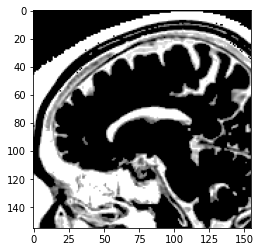

In [14]:
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(img[:, :, 50]), cmap="gray")

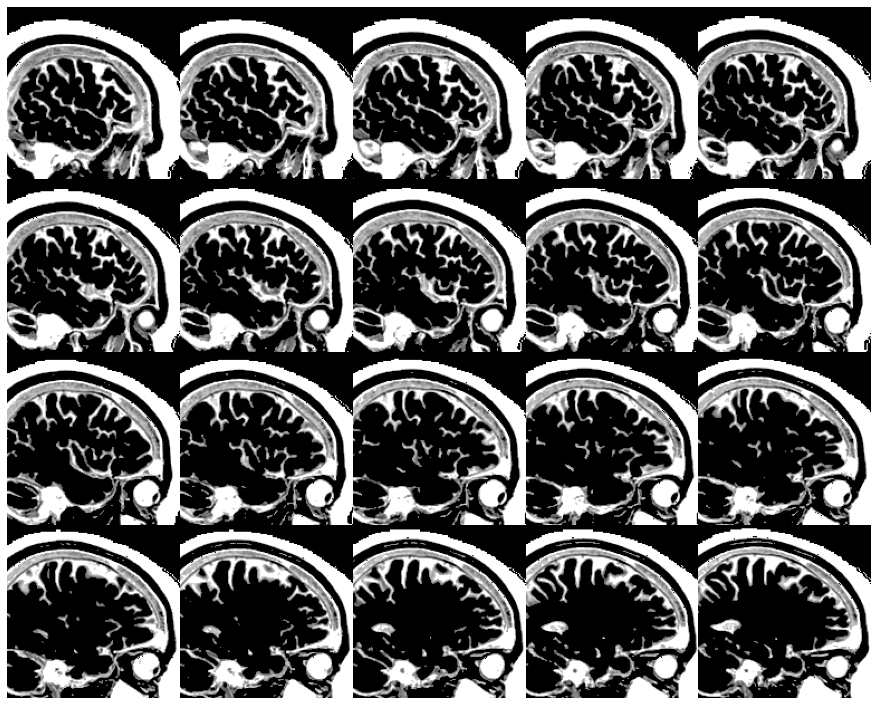

In [15]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 5, 155, 155, img[:, :, :20])


In [16]:
####Image Branches
#data_branch=dict()
x=0
for i in range(0,150,50):
    for j in range(0,150,50):
        for k in range(0,90,30):
            globals()['branch_%s' % x] = data[0:817,i:i+55, j:j+55, k:k+35]
            x+=1
                
print(x)

27


In [17]:
####Image Branches
#data_branch=dict()
'''x=0
for i in range(0,150,50):
    for j in range(0,150,50):
        for k in range(0,90,30):
            globals()['branch_%s' % x] = data[0:817,i:i+60, j:j+60, k:k+40]
            x+=1
                
print(x)'''

"x=0\nfor i in range(0,150,50):\n    for j in range(0,150,50):\n        for k in range(0,90,30):\n            globals()['branch_%s' % x] = data[0:817,i:i+60, j:j+60, k:k+40]\n            x+=1\n                \nprint(x)"

In [18]:
'''channels = 60
img_size_x = 60
img_size_y = 40
batch_size = 4
nb_classes = 3
nb_epochs = 25
learning_rate = 0.003
early_stopping_patience = 20
class_names = ["AD","CN", "MCI"]'''

'channels = 60\nimg_size_x = 60\nimg_size_y = 40\nbatch_size = 4\nnb_classes = 3\nnb_epochs = 25\nlearning_rate = 0.003\nearly_stopping_patience = 20\nclass_names = ["AD","CN", "MCI"]'

In [19]:
channels = 55
img_size_x = 55
img_size_y = 35
batch_size = 4
nb_classes = 3
nb_epochs = 25
learning_rate = 0.003
early_stopping_patience = 20
class_names = ["AD","CN", "MCI"]
num_branches = 27
batch_size = 4
nb_epochs = 10
early_stopping_patience = 20

In [20]:
import keras
from keras import backend as T
from keras.utils import np_utils
from keras.engine import Layer
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Reshape, Flatten, BatchNormalization, Lambda, Dropout, Activation, Concatenate


In [21]:
id_train,id_test=train_test_split(subjects_dict, test_size=0.1, train_size=0.9, random_state=7)

In [22]:
#branch_Y_train 
#np.sum(branch_Y_train,axis=0)

In [23]:
'''
#####Branch models############
#data = scaler.fit(data)
#best=[16,22,14,15,3]
nets = []
for v in range(0,27):
    branch=globals()['branch_%s' % v]
    branch= np.reshape(branch, (branch.shape[0], branch.shape[1], branch.shape[2], branch.shape[3], 1))
    #print(branch.shape)
    branch_X_train, branch_X_test, branch_Y_train, branch_Y_test = train_test_split(branch, labels, test_size=0.1, train_size=0.9, random_state=7)
    #X_train, X_test, Y_train_C, Y_test_C = train_test_split(data, labels_C, test_size=0.1, train_size=0.9, random_state=7)
    np.save("Labels2_tr", branch_Y_train)
    np.save("Labels2_ts", branch_Y_test)
    branch_Y_train = np_utils.to_categorical(branch_Y_train, 3)
    branch_Y_test = np_utils.to_categorical(branch_Y_test, 3)
    branch_input = Input(shape= (60,60,40,1))
    globals()['model_branch_%s' % v] = bm.build_separate_model(branch_input)
    # nets += [ globals()['model_branch_%s' % v]]
    branch_val_data = branch_X_test
    branch_val_labels = branch_Y_test
    #val_labels_C = Y_test_C
    #model_temp = multi_gpu_model(model_temp, gpus=2)
    opt = keras.optimizers.Adam(lr=2e-4)
    globals()['model_branch_%s' % v].compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])
    nets += [ globals()['model_branch_%s' % v]]
    #print(hex(id(globals()['model_branch_%s' % v])),hex(id(nets[v])))'''

'\n#####Branch models############\n#data = scaler.fit(data)\n#best=[16,22,14,15,3]\nnets = []\nfor v in range(0,27):\n    branch=globals()[\'branch_%s\' % v]\n    branch= np.reshape(branch, (branch.shape[0], branch.shape[1], branch.shape[2], branch.shape[3], 1))\n    #print(branch.shape)\n    branch_X_train, branch_X_test, branch_Y_train, branch_Y_test = train_test_split(branch, labels, test_size=0.1, train_size=0.9, random_state=7)\n    #X_train, X_test, Y_train_C, Y_test_C = train_test_split(data, labels_C, test_size=0.1, train_size=0.9, random_state=7)\n    np.save("Labels2_tr", branch_Y_train)\n    np.save("Labels2_ts", branch_Y_test)\n    branch_Y_train = np_utils.to_categorical(branch_Y_train, 3)\n    branch_Y_test = np_utils.to_categorical(branch_Y_test, 3)\n    branch_input = Input(shape= (60,60,40,1))\n    globals()[\'model_branch_%s\' % v] = bm.build_separate_model(branch_input)\n    # nets += [ globals()[\'model_branch_%s\' % v]]\n    branch_val_data = branch_X_test\n    bra

In [25]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [29]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test,Y_test))

batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


NameError: name 'X_train' is not defined

In [47]:
from tensorflow.keras import layers
def get_model(width=55, height=55, depth=35):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((55,55,35,1))

    x = layers.Conv3D(filters=8, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=8, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=nb_classes, activation="sigmoid")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3D-CNN")
    return model


# Build model.
model = get_model(width=55, height=55, depth=35)
model.summary()


Model: "3D-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 55, 55, 35, 1)]   0         
_________________________________________________________________
conv3d_136 (Conv3D)          (None, 54, 54, 34, 8)     72        
_________________________________________________________________
max_pooling3d_78 (MaxPooling (None, 27, 27, 17, 8)     0         
_________________________________________________________________
batch_normalization_186 (Bat (None, 27, 27, 17, 8)     32        
_________________________________________________________________
conv3d_137 (Conv3D)          (None, 26, 26, 16, 8)     520       
_________________________________________________________________
max_pooling3d_79 (MaxPooling (None, 13, 13, 8, 8)      0         
_________________________________________________________________
batch_normalization_187 (Bat (None, 13, 13, 8, 8)      32   

In [46]:
model

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc",tf.keras.metrics.AUC()],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100

In [48]:
#####Branch models############
#data = scaler.fit(data)
nets = []
for v in range(0,27):
    branch=globals()['branch_%s' % v]
    branch= np.reshape(branch, (branch.shape[0], branch.shape[1], branch.shape[2], branch.shape[3], 1))
    #print(branch.shape)
    branch_X_train, branch_X_test, branch_Y_train, branch_Y_test = train_test_split(branch, labels, test_size=0.1, train_size=0.9, random_state=7)
    #X_train, X_test, Y_train_C, Y_test_C = train_test_split(data, labels_C, test_size=0.1, train_size=0.9, random_state=7)
    np.save("Labels2_tr", branch_Y_train)
    np.save("Labels2_ts", branch_Y_test)
    branch_Y_train = np_utils.to_categorical(branch_Y_train, 3)
    branch_Y_test = np_utils.to_categorical(branch_Y_test, 3)
    branch_input = Input(shape= (55,55,35,1))
    globals()['model_branch_%s' % v] = get_model(branch_input)
    # nets += [ globals()['model_branch_%s' % v]]
    branch_val_data = branch_X_test
    branch_val_labels = branch_Y_test
    #val_labels_C = Y_test_C
    #model_temp = multi_gpu_model(model_temp, gpus=2)
    opt = keras.optimizers.Adam(lr=2e-4)
    globals()['model_branch_%s' % v].compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])
    nets += [ globals()['model_branch_%s' % v]]


In [49]:
for v in range(0,27):
    for i, l in enumerate(globals()['model_branch_%s' % v].layers):
        l._name = 'branch_%s' % v +'_layer_'+str(i)
#for layer in model_branch_10.layers:
#    print(layer.name)

In [50]:
# Compile joint model
merged = Concatenate()([ net.output for net in nets ])
dense_to_output = Dense(5, activation='softmax')(merged)
output = Dense(3, activation='softmax')(dense_to_output)
input_dims = [ net.inputs for net in nets ]
new_model = Model(inputs=input_dims,outputs=[output])
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

v = 100000
model_weights_file = 'SEP_weights_%s.h5' %v
epoch_weights_file = 'SEP_weights_%s_{epoch:02d}.hdf5' %v
model_file = 'SEP_model%s.h5' %v
history_file = 'SEP_history_%s.json' %v
checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
callbacks_list = [checkpoint, early_stopping]
print("Finished compiling new_model")
# print(new_model.summary())
# Create train-test splits
branch_X_trains, branch_X_tests = [],[]
branch_Y_trains, branch_Y_tests = [],[]
for v in range(27):
    branch=globals()['branch_%s' % v]
    branch= np.reshape(branch, (branch.shape[0], branch.shape[1], branch.shape[2], branch.shape[3], 1))
    #print(branch.shape)
    branch_X_train, branch_X_test, branch_Y_train, branch_Y_test = train_test_split(branch, labels, test_size=0.1, train_size=0.9, random_state=7)
    branch_X_trains += [ branch_X_train ]
    branch_X_tests += [ branch_X_test ]
    branch_Y_trains = np_utils.to_categorical(branch_Y_train, 3)
    branch_Y_tests = np_utils.to_categorical(branch_Y_test, 3)
print("Finished preparing train/test data")
#for b in range(len(branch_X_trains)):
 #   print(b,branch_X_trains[b].shape)
#print(branch_Y_trains)
# Train new model
#new_model.fit(branch_X_trains, branch_Y_trains)
#print("Finished training new_model")


Finished compiling new_model
Finished preparing train/test data


In [51]:
class_weight = {0: 204.,
                1: 360.,
                2: 171.}

In [26]:
#################################   DON'T RUN          #############
# DEBUG
"""model0 = nets[0]
model1 = nets[1]
print(hex(id(model0)))
print(hex(id(model1)))
print(hex(id(model0.inputs)))
print(hex(id(model1.inputs)))

# Initialize model0 parameters
model0 = nets[0]
branch0=globals()['branch_0']
branch0= np.reshape(branch0, (branch0.shape[0], branch0.shape[1], branch0.shape[2], branch0.shape[3], 1))
branch0_X_train, branch0_X_test, branch0_Y_train, branch0_Y_test = train_test_split(branch0, labels, test_size=0.1, train_size=0.9, random_state=7)
branch0_Y_train = np_utils.to_categorical(branch0_Y_train, 3)
branch0_Y_test = np_utils.to_categorical(branch0_Y_test, 3)
print("Finished preparing model0 paramaeters")

# Initialize model1 parameters
model1 = nets[1]
branch1=globals()['branch_1']
branch1= np.reshape(branch1, (branch1.shape[0], branch1.shape[1], branch1.shape[2], branch1.shape[3], 1))
branch1_X_train, branch1_X_test, branch1_Y_train, branch1_Y_test = train_test_split(branch1, labels, test_size=0.1, train_size=0.9, random_state=7)
branch1_Y_train = np_utils.to_categorical(branch1_Y_train, 3)
branch1_Y_test = np_utils.to_categorical(branch1_Y_test, 3)
print("Finished preparing model1 paramaeters")

# DEBUG
print("branch0_X_train.shape: " + str(branch0_X_train.shape))
print("branch1_X_train.shape: " + str(branch1_X_train.shape))
print("branch0_Y_train.shape: " + str(branch0_Y_train.shape))

# Merge two model parameters
print("model0.output: "+str(model0.output))
print("model1.output: "+str(model1.output))
merged = Concatenate()([model0.output,model1.output])
# merged = Concatenate()([ net.output for net in nets ])
print(merged.shape)
dense_to_output = Dense(5, activation='softmax')(merged)
output = Dense(3, activation='softmax')(dense_to_output)

# Compile new model
input_dims = [ model0.inputs, model1.inputs ]
# input_dims = [ net.inputs for net in nets ]
new_model = Model(inputs=input_dims,outputs=[output])
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])
print("Finished compiling new_model")

# Train new model
new_model.fit([branch0_X_train, branch1_X_train], branch0_Y_train)
print("Finished training new_model")"""

'model0 = nets[0]\nmodel1 = nets[1]\nprint(hex(id(model0)))\nprint(hex(id(model1)))\nprint(hex(id(model0.inputs)))\nprint(hex(id(model1.inputs)))\n\n# Initialize model0 parameters\nmodel0 = nets[0]\nbranch0=globals()[\'branch_0\']\nbranch0= np.reshape(branch0, (branch0.shape[0], branch0.shape[1], branch0.shape[2], branch0.shape[3], 1))\nbranch0_X_train, branch0_X_test, branch0_Y_train, branch0_Y_test = train_test_split(branch0, labels, test_size=0.1, train_size=0.9, random_state=7)\nbranch0_Y_train = np_utils.to_categorical(branch0_Y_train, 3)\nbranch0_Y_test = np_utils.to_categorical(branch0_Y_test, 3)\nprint("Finished preparing model0 paramaeters")\n\n# Initialize model1 parameters\nmodel1 = nets[1]\nbranch1=globals()[\'branch_1\']\nbranch1= np.reshape(branch1, (branch1.shape[0], branch1.shape[1], branch1.shape[2], branch1.shape[3], 1))\nbranch1_X_train, branch1_X_test, branch1_Y_train, branch1_Y_test = train_test_split(branch1, labels, test_size=0.1, train_size=0.9, random_state=7)\

In [38]:
'''# Compile joint model
merged = Concatenate()([ net.output for net in nets ])
dense_to_output = Dense(10, activation='softmax')(merged)
output = Dense(3, activation='softmax')(dense_to_output)
input_dims = [ net.inputs for net in nets]
new_model = Model(inputs=input_dims,outputs=[output])
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

v = 105
model_weights_file = 'SEP_weights_%s.h5' %v
epoch_weights_file = 'SEP_weights_%s_{epoch:02d}.hdf5' %v
model_file = 'SEP_model%s.h5' %v
history_file = 'SEP_history_%s.json' %v
checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
callbacks_list = [checkpoint, early_stopping]
print("Finished compiling new_model")
# print(new_model.summary())
# Create train-test splits
branch_X_trains, branch_X_tests = [],[]
branch_Y_trains, branch_Y_tests = [],[]
for v in range(0,27):
    branch=globals()['branch_%s' % v]
    branch= np.reshape(branch, (branch.shape[0], branch.shape[1], branch.shape[2], branch.shape[3], 1))
    #print(branch.shape)
    branch_X_train, branch_X_test, branch_Y_train, branch_Y_test = train_test_split(branch, labels, test_size=0.1, train_size=0.9, random_state=7)
    branch_X_trains += [ branch_X_train ]
    branch_X_tests += [ branch_X_test ]
    branch_Y_trains = np_utils.to_categorical(branch_Y_train, 3)
    branch_Y_tests = np_utils.to_categorical(branch_Y_test, 3)
print("Finished preparing train/test data")
#for b in range(len(branch_X_trains)):
#    print(b,branch_X_trains[b].shape)
#print(branch_Y_trains)
'''

'# Compile joint model\nmerged = Concatenate()([ net.output for net in nets ])\ndense_to_output = Dense(10, activation=\'softmax\')(merged)\noutput = Dense(3, activation=\'softmax\')(dense_to_output)\ninput_dims = [ net.inputs for net in nets]\nnew_model = Model(inputs=input_dims,outputs=[output])\nnew_model.compile(optimizer=opt, loss=\'categorical_crossentropy\', metrics=[tf.keras.metrics.AUC()])\n\nv = 105\nmodel_weights_file = \'SEP_weights_%s.h5\' %v\nepoch_weights_file = \'SEP_weights_%s_{epoch:02d}.hdf5\' %v\nmodel_file = \'SEP_model%s.h5\' %v\nhistory_file = \'SEP_history_%s.json\' %v\ncheckpoint = ModelCheckpoint(epoch_weights_file, monitor=\'val_loss\', verbose=1, save_best_only=True, mode=\'min\')\nearly_stopping = EarlyStopping(monitor=\'val_loss\', min_delta=0, patience=early_stopping_patience, verbose=1, mode=\'auto\')\ncallbacks_list = [checkpoint, early_stopping]\nprint("Finished compiling new_model")\n# print(new_model.summary())\n# Create train-test splits\nbranch_X_t

In [ ]:
# Train new model
m=new_model.fit(branch_X_trains, branch_Y_trains,batch_size=batch_size,epochs=60, verbose=1, shuffle=True, validation_data=(branch_X_tests, branch_Y_tests),class_weight=class_weight)
print("Finished training new_model")

Epoch 1/60
184/184 [==============================] - 392s 2s/step - loss: 253.0889 - auc_55: 0.6222 - accuracy: 0.4898 - val_loss: 1.0355 - val_auc_55: 0.6498 - val_accuracy: 0.5000
Epoch 2/60
184/184 [==============================] - 384s 2s/step - loss: 248.8797 - auc_55: 0.6397 - accuracy: 0.4898 - val_loss: 1.0377 - val_auc_55: 0.6546 - val_accuracy: 0.5000
Epoch 3/60
184/184 [==============================] - 384s 2s/step - loss: 247.1098 - auc_55: 0.6463 - accuracy: 0.4898 - val_loss: 1.0405 - val_auc_55: 0.6430 - val_accuracy: 0.5000
Epoch 4/60
184/184 [==============================] - 392s 2s/step - loss: 246.0101 - auc_55: 0.6459 - accuracy: 0.4898 - val_loss: 1.0439 - val_auc_55: 0.6518 - val_accuracy: 0.5000
Epoch 5/60
184/184 [==============================] - 379s 2s/step - loss: 244.8574 - auc_55: 0.6531 - accuracy: 0.4898 - val_loss: 1.0467 - val_auc_55: 0.6433 - val_accuracy: 0.5000
Epoch 6/60
184/184 [==============================] - 387s 2s/step - loss: 244.3879 -

In [ ]:
def save_model_and_weights(model):
        model.save(model_file)
        model.save_weights(model_weights_file)

def save_model_history(m):
    with open(history_file, 'wb') as history_json_file:
        json.dump(m.history, history_json_file)

    return 'Saved model history to disk'
print(save_model_and_weights(new_model))
#print(save_model_history(m))
#del model_temp
#del m
gc.collect()

In [ ]:
'''neuron_model=Model(inputs=input_dims ,outputs=new_model.layers[-3].output)
features = neuron_model.predict(branch_X_tests)
print(features.shape)
features'''

In [ ]:
##saving the value in a list
'''
pred=[]
for j in range(1,len(id_test)):
    feat1=[]
    feat2=[]
    feat3=[]
    for i in range(0,81,3):
        feat1+=[features[j][i]]
        feat2+=[features[j][i+1]]
        feat3+=[features[j][i+2]]
    pred+=[np.mean(feat1),np.mean(feat2),np.mean(feat3)]   ''' 

In [ ]:
### saving the value in an array
'''pred=[]
pred1=[]
#print(pred1)
for j in range(1,len(id_test)):
    feat1=[]
    feat2=[]
    feat3=[]
    for i in range(0,81,3):
        feat1+=[features[j][i]]
        feat2+=[features[j][i+1]]
        feat3+=[features[j][i+2]]
    pred1=[np.mean(feat1),np.mean(feat2),np.mean(feat3)]
    pred.append(pred1)
pred'''

In [ ]:
'''print(np.mean(feat1))
print(np.mean(feat2))
print(np.mean(feat3))'''

In [ ]:
id_test

In [ ]:
'''####DELETE LATER
for v in best:
    branch=globals()['branch_%s' % v]
    branch= np.reshape(branch, (branch.shape[0], branch.shape[1], branch.shape[2], branch.shape[3], 1))
    #print(branch.shape)
    branch_X_train, branch_X_test, branch_Y_train, branch_Y_test = train_test_split(branch, labels, test_size=0.1, train_size=0.9, random_state=7)
    branch_X_trains += [ branch_X_train ]
    branch_X_tests += [ branch_X_test ]
    branch_Y_trains = np_utils.to_categorical(branch_Y_train, 3)
    branch_Y_tests = np_utils.to_categorical(branch_Y_test, 3)
print("Finished preparing train/test data")
#for b in range(len(branch_X_trains)):
#    print(b,branch_X_trains[b].shape)
#print(branch_Y_trains)
# Train new model
m=new_model.fit(branch_X_trains, branch_Y_trains,batch_size=batch_size,epochs=50, verbose=1, shuffle=True, validation_data=(branch_X_tests, branch_Y_tests), callbacks=[checkpoint])
print("Finished training new_model")
'''

In [ ]:
'''from keras.utils.vis_utils import plot_model
plot_model(new_model, to_file='new_model_plot.png', show_shapes=True, show_layer_names=True)'''

In [ ]:
'''def save_model_and_weights(model):
        model.save(model_file)
        model.save_weights(model_weights_file)

def save_model_history(m):
    with open(history_file, 'wb') as history_json_file:
        json.dump(m.history, history_json_file)

    return 'Saved model history to disk'
print(save_model_and_weights(new_model))
#print(save_model_history(m))
#del model_temp
#del m
gc.collect()'''

In [17]:
'''new_model.load_weights("SEP_weights_105_01.hdf5")'''


In [25]:
'''neuron_model=Model(inputs=input_dims,outputs=new_model.layers[-2].output)'''


In [26]:
'''features_train = neuron_model.predict(branch_X_trains)'''

In [27]:
'''features_test=neuron_model.predict(branch_X_tests)'''


In [28]:
'''neuron_model=Model(inputs=input_dims,outputs=new_model.layers[-2].output)
features_train = neuron_model.predict(branch_X_trains)
features_test=neuron_model.predict(branch_X_tests)
feature_extrc=np.concatenate((features_train,features_test))
feature_extrc.shape'''

(817, 10)

In [29]:
'''print(features_train.shape)
print(features_test.shape)'''

(735, 10)
(82, 10)


In [30]:
'''feature_extrc=pd.concat([pd.DataFrame(feature_extrc),pd.DataFrame(labels)],axis=1)
pd.DataFrame(feature_extrc).to_csv("/home/dipnilc/Dipnil/SEP_features_60.csv", header=None, sep=',',index=None)'''

In [ ]:

"""
x=50
model_weights_file = 'img_classifierW_weights_%s.h5' %x
epoch_weights_file = 'img_classifierW_weights_%s_{epoch:02d}.hdf5' %x
model_file = 'img_classifierW_model%s.h5' %x
history_file = 'img_classifierW_history_%s.json' %x
    
#merged = Concatenate()([model_branch_16, model_branch_22,model_branch_15,model_branch_14,model_branch_3])
#merged1=Dense(100, activation='softmax')(merged)
#output = Dense(3, activation='softmax')(merged1)
#model_final=Model()
nets1=Concatenate()(nets)
merged = Dense(50, activation='softmax')(nets1)
merged1 = Dense(3, activation='softmax')(merged)
model_inputs = [ tf.keras.Input(shape=(55,55,35,1)) for i in range(27) ]

final_model=Model(inputs=model_inputs,outputs=[merged1])
final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])  

checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
callbacks_list = [checkpoint, early_stopping]
#datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,samplewise_std_normalization=False,zca_whitening=False,rotation_range=15,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=False,vertical_flip=False)
#globals()['model_branch_%s' % v].summary()
#globals()['models_br_%s' % v] = globals()['model_branch_%s' % v].fit(branch_X_train,branch_Y_train,batch_size=batch_size,epochs=1, verbose=1, shuffle=True, validation_data=(branch_val_data, branch_val_labels), callbacks=[checkpoint])
    """